<a href="https://colab.research.google.com/github/itsarifworld/Image-Denoising-Classification/blob/main/challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---



---


# **IMAGE DENOISING AND CLASSIFICATION**


---



---




---


## **IMPORTS**


---



In [6]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm




---


## **DATASETS**


---


In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [8]:
# DEFINING ROOTPATHS:

train_noisy_dir = ('/content/drive/MyDrive/ML Project/train/noisy')
train_clean_dir = ('/content/drive/MyDrive/ML Project/train/clean')

test_noisy_dir = ('/content/drive/MyDrive/ML Project/test/noisy')
#test_clean_dir = ('/content/drive/MyDrive/ML Project/test/clean')
test_clean_dir = ('/content/drive/MyDrive/ML Project/test/denoised_images')


In [9]:
# VERIFYING THAT FOLDER EXISTS

for path in [train_noisy_dir, train_clean_dir, test_noisy_dir, test_clean_dir]:
  if not os.path.exists(path):
    print(f"Missing Path : {path}")
  else :
    print(f"Path Found : {path}")

Path Found : /content/drive/MyDrive/ML Project/train/noisy
Path Found : /content/drive/MyDrive/ML Project/train/clean
Path Found : /content/drive/MyDrive/ML Project/test/noisy
Path Found : /content/drive/MyDrive/ML Project/test/denoised_images


In [10]:
!mkdir -p "/content/drive/MyDrive/ML Project/test/denoised_images"

In [11]:
# CHECK THE CATEGORIES INSIDE TRAIN / TEST
categories = os.listdir(train_noisy_dir)
print(f"Categories in Noisy Train Folder : {categories}")

Categories in Noisy Train Folder : ['roses', 'sunflowers', 'tulips', 'dandelion', 'daisy']


In [12]:
# CHECKING SAMPLE IMAGE FILE

sample_category = categories[0]

sample_path = os.path.join(
    train_noisy_dir,
    sample_category,
    os.listdir(os.path.join(train_noisy_dir,sample_category))[0]
)   # GIVES THE PATH FOR 1ST IMAGE IN CATEGORY[0] : ' ROSES '

print(sample_path)

/content/drive/MyDrive/ML Project/train/noisy/roses/Image_Train_757.png


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

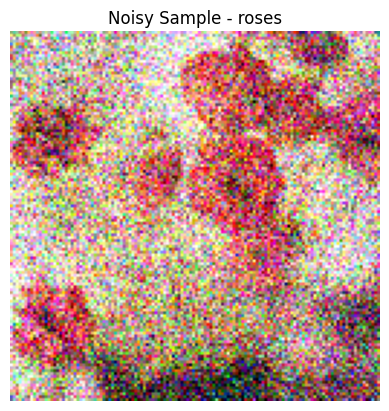

In [13]:
# READING THE IMAGE

img = cv2.imread(sample_path)

# since OpenCV reads the image in BGR colour code, we need to convert it into RGB

conv_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# SHOWING THE IMAGE

plt.imshow(conv_img)
plt.title(f"Noisy Sample - {sample_category}")
plt.axis("off")



---


## **LOADING THE IMAGE IN PAIRED FORM**


---



> While training denoising in autoencoder we must ensure that ( NOISY IMAGE ---> Corresponding CLEAN IMAGE )



In [14]:
# pick first category
sample_category = categories[0]
print(f"Current Flower Sample is : {sample_category}")

noisy_files = os.listdir(os.path.join(train_noisy_dir, sample_category))
print(f"Current Working Directory is : {noisy_files}")

sample_file = noisy_files[0]
print(f"In the category {sample_category}, The selected image is {sample_file}")

# creating full paths for noisy and clean version
noisy_path = os.path.join(train_noisy_dir, sample_category, sample_file)
clean_path = os.path.join(train_clean_dir, sample_category, sample_file)

print(f"The noisy path is : {noisy_path}")
print(f"The clean path is : {clean_path}")

# ------------------------------------------------------
# Now we have corresponding clean image for noisy image
# ------------------------------------------------------

noisy_img = cv2.imread(noisy_path)
clean_img = cv2.imread(clean_path)

# Converting image from BGR to RGB
noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)
clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2RGB)

Current Flower Sample is : roses
Current Working Directory is : ['Image_Train_757.png', 'Image_Train_936.png', 'Image_Train_946.png', 'Image_Train_1006.png', 'Image_Train_960.png', 'Image_Train_933.png', 'Image_Train_913.png', 'Image_Train_1062.png', 'Image_Train_880.png', 'Image_Train_1004.png', 'Image_Train_1035.png', 'Image_Train_918.png', 'Image_Train_790.png', 'Image_Train_993.png', 'Image_Train_980.png', 'Image_Train_1044.png', 'Image_Train_1009.png', 'Image_Train_938.png', 'Image_Train_878.png', 'Image_Train_966.png', 'Image_Train_1055.png', 'Image_Train_898.png', 'Image_Train_896.png', 'Image_Train_874.png', 'Image_Train_968.png', 'Image_Train_1054.png', 'Image_Train_799.png', 'Image_Train_995.png', 'Image_Train_761.png', 'Image_Train_916.png', 'Image_Train_892.png', 'Image_Train_927.png', 'Image_Train_752.png', 'Image_Train_1041.png', 'Image_Train_987.png', 'Image_Train_1032.png', 'Image_Train_965.png', 'Image_Train_932.png', 'Image_Train_825.png', 'Image_Train_869.png', 'Imag

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

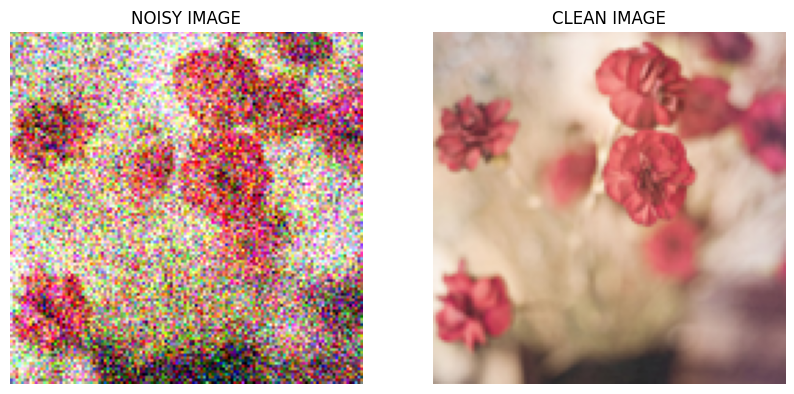

In [15]:
# PLOTTING THE IMAGES SIDE BY SIDE

plt.figure(figsize=(10,5))

# PLOTTING NOISY IMAGE

plt.subplot(1,2,1)
plt.imshow(noisy_img)
plt.title("NOISY IMAGE")
plt.axis("off")

# PLOTTING CLEAN IMAGE

plt.subplot(1,2,2)
plt.imshow(clean_img)
plt.title("CLEAN IMAGE")
plt.axis("off")




---


## **BULK LOADING OF DATASETS INTO NUMPY ARRAYS**

---




1.   Loop through each category
2.   Inside it, Loop through each image.
3.   Load the noisy version of X.
4.   Load the clean version of Y
5.   Normalise pixel values (0–255 → 0–1).





In [16]:
from tqdm import tqdm   # PROGRESS BAR

IMG_SIZE = (128, 128)
def load_data_set(noisy_dir, clean_dir):
  X_data = []
  Y_data = []


  for category in tqdm(categories, desc = 'Loading Categories'):
                                                         #| IN FIRST LOOP
    noisy_folder = os.path.join(noisy_dir, category)     #| 'dataset/noisy/roses
    clean_folder = os.path.join(clean_dir, category)     #| 'dataset/clean/roses

    for file in os.listdir(noisy_folder):
      noisy_path = os.path.join(noisy_folder, file)      #| 'dataset/noisy/roses/1.png
      clean_path = os.path.join(clean_folder, file)      #| 'dataset/clean/roses/1.png

      # READING AND RESIZING THE IMAGE
      noisy_img = cv2.imread(noisy_path)   # READ
      noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)   # CONVERTS BGR --> RGB
      noisy_img = cv2.resize(noisy_img, IMG_SIZE)    # RESIZES IMAGES INTO ( 128,128 )


      clean_img = cv2.imread(clean_path)
      clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2RGB)
      clean_img = cv2.resize(clean_img, IMG_SIZE)


      # NORMALIZING THE PIXEL VALUE
      noisy_img = noisy_img.astype('float32')/255.0
      clean_img = clean_img.astype('float32')/255.0

      X_data.append(noisy_img)
      Y_data.append(clean_img)

    # converting list to numpy array
  return np.array(X_data), np.array(Y_data)

In [17]:
# LOADING THE TRAINING DATA
X_train, Y_train = load_data_set(train_noisy_dir, train_clean_dir)

Loading Categories: 100%|██████████| 5/5 [11:02<00:00, 132.40s/it]


In [18]:
# FOR TEST DATA
def load_test_data(noisy_dir):
  X_data = []

  for path in tqdm(os.listdir(noisy_dir), desc = 'Loading Test Data'):
    noisy_path = os.path.join(noisy_dir, path)   # MAKING THE PATH TO ACCESS IMAGES INSIDE TEST DATASET

    noisy_img = cv2.imread(noisy_path)     # READ

    noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)    # BGR --> RGB

    noisy_img = cv2.resize(noisy_img, IMG_SIZE)

    # NORMALISE THE IMAGES

    noisy_img = noisy_img.astype('float32')/255.0
    X_data.append(noisy_img)

  return np.array(X_data)

In [19]:
# LOADING THE TEST DATA
X_test = load_test_data(test_noisy_dir)

Loading Test Data: 100%|██████████| 772/772 [00:18<00:00, 42.71it/s] 


In [20]:
# CHECKING THE SHAPES OF THE DATA
print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of Y_train : {Y_train.shape}")
print(f"Shape of X_test : {X_test.shape}")

Shape of X_train : (1795, 128, 128, 3)
Shape of Y_train : (1795, 128, 128, 3)
Shape of X_test : (772, 128, 128, 3)




---


##**AUTOENCODER**

---



In [21]:
from tensorflow.keras import layers, models

In [22]:
# AUTOENCODER MODEL
def build_autoencoder(input_shape = (128,128,3)):
  inputs = layers.Input(shape = input_shape)


 # -----------------------------------------------------------
 # ENCODER
 # -----------------------------------------------------------

  x = layers.Conv2D(
      32,      # layers will produce 32 output channels
      (3,3),   # each filter is a small window of 3x3 pixels
      activation="relu",    # Rectified Learning Unit [ ReLU(x) = max(0,x), introduces non-linearity, allowing the network to learn complex shapes (faces, flowers)]
      padding = "same"   # Output spatial size is same as input size
      )(inputs)
  x = layers.MaxPooling2D(
      (2,2),     # Reduces height and width by factor of 2
      padding = "same"
      )(x)

  x = layers.Conv2D(64,(3,3), activation = "relu", padding = "same")(x)
  x = layers.MaxPooling2D((2,2), padding = "same")(x)

  x = layers.Conv2D(128,(3,3), activation="relu", padding="same")(x)
  encoded = layers.MaxPooling2D((2,2), padding="same")(x)

 # -----------------------------------------------------------
 # DECODER
 # -----------------------------------------------------------

  x = layers.Conv2DTranspose(128, (3,3), strides = 2, activation="relu", padding="same")(encoded)  #strides = 2 --> doubles the height and width
  x = layers.Conv2DTranspose(64, (3,3), strides = 2, activation='relu', padding="same")(x)
  x = layers.Conv2DTranspose(32, (3,3), strides = 2, activation="relu", padding="same")(x)

  decoded = layers.Conv2D(3, (3,3), activation="sigmoid", padding="same")(x)


  # BUILD MODEL
  autoencoder = models.Model(inputs, decoded)
  return autoencoder

# CREATING THE MODEL
autoencoder = build_autoencoder()

# COMPILING THE MODEL
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)



---


##**TRAINING THE MODEL**


---



In [23]:
train = autoencoder.fit(
    X_train, Y_train,
    epochs = 20,
    batch_size = 32,  #small enough for fast updates, large enough for stable training.
    validation_split = 0.1,  #10% of X_train, Y_train is kept aside during training, To monitor overfitting
    shuffle = True
)

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step - loss: 0.0812 - val_loss: 0.0448
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0324 - val_loss: 0.0187
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0168 - val_loss: 0.0154
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0143 - val_loss: 0.0134
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0130 - val_loss: 0.0120
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0119 - val_loss: 0.0114
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0105 - val_loss: 0.0101
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0092 - val_loss: 0.0098
Epoch 9/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0086 - val_loss: 0.0102
Epoch 10/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0088 - val_loss: 0.0097
Epoch 11/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0085 - val_loss: 0.0090
Epoch 12/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0

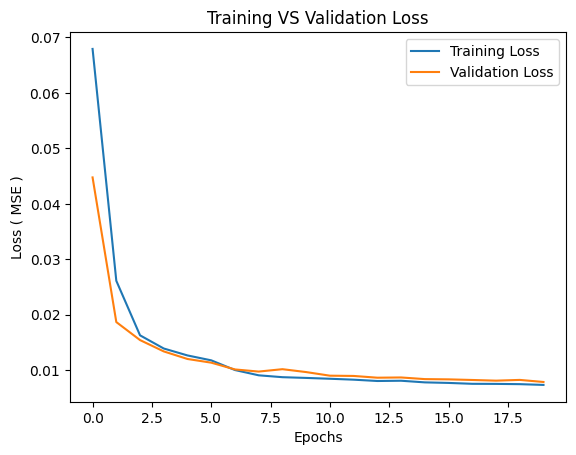

In [24]:
# PLOTTING THE LOSS OF TRAINING AND VALIDATION

plt.plot(train.history['loss'], label = "Training Loss")
plt.plot(train.history['val_loss'], label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss ( MSE )")
plt.title("Training VS Validation Loss")
plt.show()



---


**EVALUATION AND VISUALISATION**


---



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


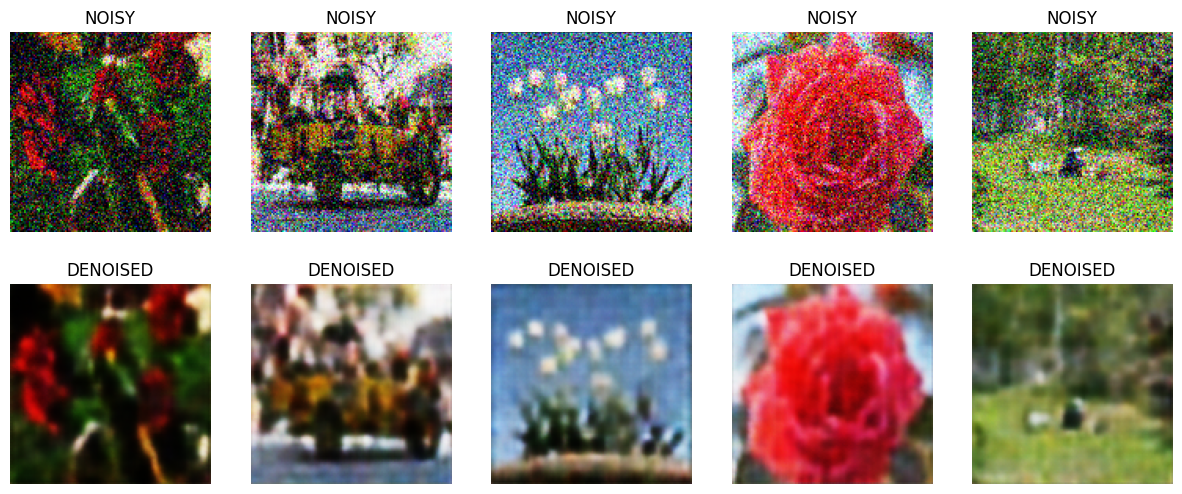

In [25]:
# PICKING ANY RANDOM 5 TEST IMAGES
n = 5
plt.figure(figsize = (15, 6))

for i in range(n):
  noisy_img = X_test[i]  # any test image

  denoised_img = autoencoder.predict(np.expand_dims(noisy_img, axis=[0]))[0]   # PREDICTING DENOISED VERSION

  # NOISY
  ax = plt.subplot(2, n, i+1)
  plt.imshow(noisy_img)
  plt.title("NOISY")
  plt.axis("off")

  # DENOISED
  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(denoised_img)
  plt.title("DENOISED")
  plt.axis("off")
plt.show()



---


## **APPLYING THE MODEL ON TEXT DATA AND SAVING IT**


---



In [26]:
denoised_images = autoencoder.predict(X_test)
X_test.shape

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


(772, 128, 128, 3)

In [27]:
# SAVING THE IMAGES IN denoised_Images
from tensorflow.keras.preprocessing.image import array_to_img

output_directory = test_clean_dir

for i, img in enumerate(denoised_images):
  image_to_save = array_to_img(img)
  image_to_save.save(os.path.join(output_directory, f"denoised_image_{i}.png"))


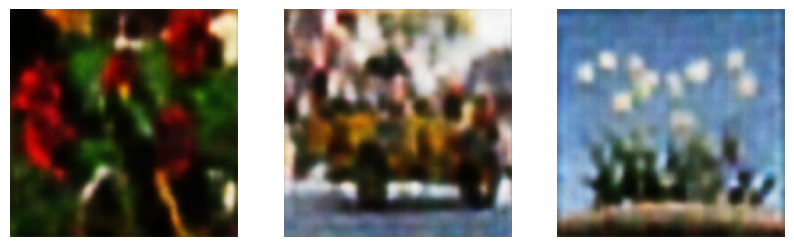

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(denoised_images[i])
    plt.axis('off')
plt.show()



---



---


#**CLASSIFICATION**


---



---




1.   Data Loading & Preprocessing
2.   Model Definition
3.   Model Training
4.   Model Evaluation
5.   Predictions on New Images







---


##**DATA PREPROCESSING**


---



In [32]:
os.listdir('/content/drive/MyDrive/ML Project/train')

['clean', 'noisy']

In [33]:
data_directory = ('/content/drive/MyDrive/ML Project/train')
IMG_SIZE = (224,224)
BATCH_SIZE = 32

path = os.listdir(data_directory)

IMG_SIZE = (256, 256)  # or (128,128) for smaller images
BATCH_SIZE = 32
SEED = 123
# load clean dataset
clean_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_directory, path[0]),
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

clean_val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_directory, path[0]),
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

#  Load NOISY dataset
noisy_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_directory, path[1]),
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

noisy_val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_directory, path[1]),
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


train_ds = clean_ds.concatenate(noisy_ds)
val_ds   = clean_val_ds.concatenate(noisy_val_ds)


# NORMALIZATION
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))

class_names = clean_ds.class_names
print("Flower Classes:", class_names)

Found 1795 files belonging to 5 classes.
Using 1436 files for training.
Found 1795 files belonging to 5 classes.
Using 359 files for validation.
Found 1795 files belonging to 5 classes.
Using 1436 files for training.
Found 1795 files belonging to 5 classes.
Using 359 files for validation.
Flower Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']




---


##**CNN MODEL**


---



In [34]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from tensorflow.keras.layers import Dense, BatchNormalization

model_directory = '/content/drive/MyDrive/ML Project/cnn_model'
os.makedirs(model_directory, exist_ok=True)

input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)

inputs = keras.Input(shape = input_shape)

# DATA AUGMENTATION : Randomly rotates images to prevent memorization

data_augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.06),
], name = "Data_Augmentation")

x = data_augment(inputs)

# CONVOLUTION LAYER 1
x = layers.Conv2D(filters = 32, kernel_size = 3, padding = "same", activation="relu")(x)
x = layers.MaxPooling2D()(x)

# CONVOLUTION LAYER 2
x = layers.Conv2D(filters = 64, kernel_size = 3, padding = "same", activation="relu")(x)
x = layers.MaxPooling2D()(x)

# CONVOLUTION LAYER 3
x = layers.Conv2D(filters = 128, kernel_size = 3, padding = "same", activation = "relu")(x)
x = layers.MaxPooling2D()(x)

# FLATTENING > 2D features ---> 1D Vector ( for classifier )
x = layers.Flatten()(x)

x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation = "relu")(x)


outputs = layers.Dense(len(class_names), activation="softmax")(x)

# MODEL
model = keras.Model(inputs = inputs, outputs = outputs, name = "flower_cnn")

# COMPILE
model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = keras.optimizers.Adam(learning_rate = 1e-4),
    metrics = ["accuracy"]
)

model.summary()


Model: "flower_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Data_Augmentation (Sequential)  │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,871,237 (64.36 MB)

 Trainable params: 16,871,237 (64.36 MB)

 Non-trainable params: 0 (0.00 B)



---


##**TRAINING MODEL**


---



In [35]:
EPOCH = 25

checkpoint_path = os.path.join(model_directory, "best_model.keras")    # filename where we save the best model during training

# CALLBACK
callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path,
                                    monitor="val_accuracy",
                                    save_best_only=True,
                                    mode="max",
                                    verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,
                                  restore_best_weights=True, verbose=1)
]



# TRAINING THE MODEL

train = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCH,
    callbacks = callbacks
)

# SAVING THE MODEL
final_model_path = os.path.join(model_directory, "final_flower_model.keras")
model.save(final_model_path, include_optimizer=False)

Epoch 1/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.3559 - loss: 1.4371
Epoch 1: val_accuracy improved from -inf to 0.50557, saving model to /content/drive/MyDrive/ML Project/cnn_model/best_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 34s 298ms/step - accuracy: 0.3566 - loss: 1.4359 - val_accuracy: 0.5056 - val_loss: 1.1616
Epoch 2/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5186 - loss: 1.1660
Epoch 2: val_accuracy improved from 0.50557 to 0.57382, saving model to /content/drive/MyDrive/ML Project/cnn_model/best_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 237ms/step - accuracy: 0.5187 - loss: 1.1658 - val_accuracy: 0.5738 - val_loss: 1.1035
Epoch 3/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5871 - loss: 1.0694
Epoch 3: val_accuracy improved from 0.57382 to 0.59053, saving model to /content/drive/MyDrive/ML Project/cnn_model/best_model.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 34s 159ms/step - accuracy: 0.5871 - loss: 1.0693 - val_accuracy: 0.5905 - val_loss:

In [36]:
print(f"Training Accuracy : {train.history['accuracy'][-1]}")

Training Accuracy : 0.8116295337677002


In [37]:
print(final_model_path)

/content/drive/MyDrive/ML Project/cnn_model/final_flower_model.keras


In [38]:
def plot_history(hist):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))

    # Accuracy
    axes[0].plot(hist.history["accuracy"], label="train_acc")
    axes[0].plot(hist.history["val_accuracy"], label="val_acc")
    axes[0].set_title("Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].legend()

    # Loss
    axes[1].plot(hist.history["loss"], label="train_loss")
    axes[1].plot(hist.history["val_loss"], label="val_loss")
    axes[1].set_title("Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].legend()

    plt.show()

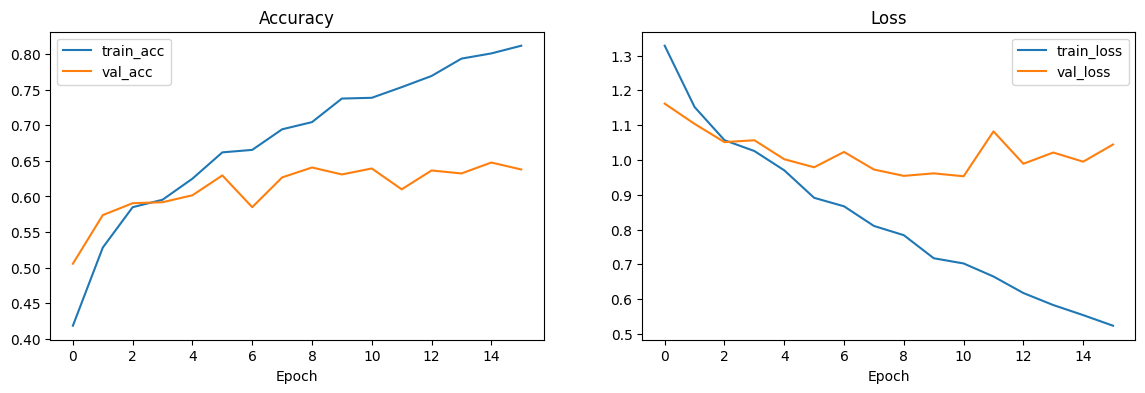

In [39]:
plot_history(train)

In [40]:
# Final Evaluation
evaluation_result = model.evaluate(val_ds)
print("Validation Loss, Accuracy", evaluation_result)

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.6381 - loss: 0.9701
Validation Loss, Accuracy [0.9530112743377686, 0.6392757892608643]


In [41]:
y_pred, y_true = [], []
for images, labels in val_ds:
  preds = model.predict(images)
  preds_labels = np.argmax(preds, axis=1)
  y_pred.extend(preds_labels.tolist())
  y_true.extend(labels.numpy().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

try:
  from sklearn.metrics import confusion_matrix, classification_report
  print("Classification Report :\n", classification_report(y_true, y_pred, target_names=class_names))
  print("Confusion Matrix : \n", confusion_matrix(y_true, y_pred))
except ImportError:
  cm = tf.math.confusion_matrix(y_true, y_pred)
  print("Confusion Matrix (TensorFlow):\n", cm.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Classification Report :
               precision    recall  f1-score   support

      



---


##**CLASSIFYING THE IMAGES**


---



In [42]:
# path to denoised image section
denoised_directory = '/content/drive/MyDrive/ML Project/test/noisy'

# loading the saved best model
model = keras.models.load_model(os.path.join(model_directory, "best_model.h5"))

# loading the denoised test data
test_ds = keras.utils.image_dataset_from_directory(
    denoised_directory,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    shuffle=False,
    labels=None
)

# normalisation
normalization_layer = tf.keras.layers.Rescaling(1./255)
test_ds = test_ds.map(lambda x: (normalization_layer(x)))

# prediction
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

Found 772 files.
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step




---


**SAVING THE IMAGES**


---



In [ ]:
# path where .csv will be saved
csv_file = '/content/drive/MyDrive/ML Project/test/test_labels.csv'

#file_paths = test_ds.file_paths

import glob

file_paths = sorted(glob.glob(os.path.join(denoised_directory, "*")))
file_names = [os.path.basename(path) for path in file_paths]

In [ ]:
import pandas as pd
results_df = pd.DataFrame({
    "Images" : file_names,
    "Predicted_Class" : predicted_classes
})

results_df.to_csv(csv_file, index=False)
print(f"Prediction saved to :{csv_file}")

In [ ]:
df_check = pd.read_csv(csv_file)
df_check.head()

In [43]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [56]:
def evaluate_psnr_ssim(X_test, denoised_images, clean_dir, img_size=(128,128)):
    psnr_noisy, ssim_noisy = [], []
    psnr_denoised, ssim_denoised = [], []

    clean_files = sorted(os.listdir(clean_dir))  # clean test images
    assert len(clean_files) == len(X_test), "Mismatch: number of clean and test images differ!"

    for i in tqdm(range(len(clean_files)), desc="Evaluating Metrics"):
        clean_path = os.path.join(clean_dir, clean_files[i])

        # Load clean image
        clean_img = cv2.imread(clean_path)
        clean_img = cv2.cvtColor(cv2.resize(clean_img, img_size), cv2.COLOR_BGR2RGB).astype('float32')/255.0

        noisy_img = X_test[i]           # already normalized [0,1]
        denoised_img = denoised_images[i]  # already normalized [0,1]

        # Compute metrics
        psnr_noisy.append(psnr(clean_img, noisy_img, data_range=1))
        ssim_noisy.append(ssim(clean_img, noisy_img, channel_axis=2, data_range=1))

        psnr_denoised.append(psnr(clean_img, denoised_img, data_range=1))
        ssim_denoised.append(ssim(clean_img, denoised_img, channel_axis=2, data_range=1))

    print("\n Average Metrics:")
    print(f"  Noisy   → PSNR: {np.mean(psnr_noisy):.2f}, SSIM: {np.mean(ssim_noisy):.4f}")
    print(f"  Denoised→ PSNR: {np.mean(psnr_denoised):.2f}, SSIM: {np.mean(ssim_denoised):.4f}")

    return psnr_noisy, ssim_noisy, psnr_denoised, ssim_denoised

In [57]:
denoised_images = autoencoder.predict(X_test)

psnr_noisy, ssim_noisy, psnr_denoised, ssim_denoised = evaluate_psnr_ssim(
    X_test, denoised_images, test_clean_dir, img_size=(128,128)
)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


Evaluating Metrics: 100%|██████████| 772/772 [00:13<00:00, 57.00it/s]


📊 Average Metrics:
  Noisy   → PSNR: 7.88, SSIM: 0.0138
  Denoised→ PSNR: 9.02, SSIM: 0.1423
